<h1 style="color:blue; background:lightblue; line-height:1.5; text-align:center">* Quora Question Pair Similarity using Word2Vec and ML Models*</h1>

<h2 style="color:blue; background:pink; line-height:1.5">Import required libraries</h2>

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

<h2 style="color:blue; background:pink; line-height:1.5">Loading Dataset which has extracted features and Preprocessed</h2>

**Dataset link:** https://drive.google.com/file/d/1rxPJHAvSXzOPEpIqmaAsXvhJK8p4K4JN/view?usp=sharing

**Preprocessed Dataset link:** https://drive.google.com/file/d/1gKfuAAzJRs-l-0ftJgb-NQj8-PQrLqtn/view?usp=sharing

In [65]:
df=pd.read_csv('data/feat_extr_data.csv')
df.head()

,question1,question2,is_duplicate,que1_len,que2_len,que1_num_words,que2_num_words,total_words,common_words,shared_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,long_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,what minor would complement a computer science...,what is a good minor that will compliment a co...,1,52,66,8,12,19,8,0.42,...,0.499996,1.0,1.0,4.0,10.0,0.547170,81,85,81,83
1,how can i materialize an idea,what is the best way to materialize on an idea,1,29,46,6,10,16,2,0.12,...,0.299997,1.0,0.0,4.0,8.0,0.433333,64,72,53,79
2,what was the happiest day of your life and why...,what was is will be the happiest day of your life,1,53,49,12,11,22,11,0.50,...,0.666661,0.0,1.0,1.0,11.5,0.600000,75,78,84,88
3,what role project manager has in agile projects,what is the role of project management in agil...,1,47,68,8,11,19,8,0.42,...,0.454541,0.0,1.0,3.0,9.5,0.312500,64,70,59,71
4,who will win in america presidential elections...,between trump and clinton who will win us pres...,1,54,63,9,10,18,8,0.44,...,0.399996,0.0,0.0,1.0,9.5,0.400000,60,77,65,68


<h2 style="color:blue; background:pink; line-height:1.5">Dataset information</h2>

In [66]:
df.shape

(49998, 25)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49998 entries, 0 to 49997
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   question1           49998 non-null  object 
 1   question2           49998 non-null  object 
 2   is_duplicate        49998 non-null  int64  
 3   que1_len            49998 non-null  int64  
 4   que2_len            49998 non-null  int64  
 5   que1_num_words      49998 non-null  int64  
 6   que2_num_words      49998 non-null  int64  
 7   total_words         49998 non-null  int64  
 8   common_words        49998 non-null  int64  
 9   shared_words        49998 non-null  float64
 10  cwc_min             49998 non-null  float64
 11  cwc_max             49998 non-null  float64
 12  csc_min             49998 non-null  float64
 13  csc_max             49998 non-null  float64
 14  ctc_min             49998 non-null  float64
 15  ctc_max             49998 non-null  float64
 16  last

<h2 style="color:blue; background:pink; line-height:1.5">Missing values</h2>

In [68]:
df.isnull().sum()

question1             0
question2             0
is_duplicate          0
que1_len              0
que2_len              0
que1_num_words        0
que2_num_words        0
total_words           0
common_words          0
shared_words          0
cwc_min               0
cwc_max               0
csc_min               0
csc_max               0
ctc_min               0
ctc_max               0
last_word_eq          0
first_word_eq         0
abs_len_diff          0
mean_len              0
long_substr_ratio     0
fuzz_ratio            0
fuzz_partial_ratio    0
token_sort_ratio      0
token_set_ratio       0
dtype: int64

<h2 style="color:blue; background:pink; line-height:1.5">Data Balance check</h2>

In [69]:
class_balance=pd.DataFrame(df['is_duplicate'].value_counts()).reset_index()
class_balance.columns=["Class", "Count"]
class_balance['Percentage']=(class_balance['Count']/df.shape[0])*100
class_balance

,Class,Count,Percentage
0,1,25000,50.002
1,0,24998,49.998


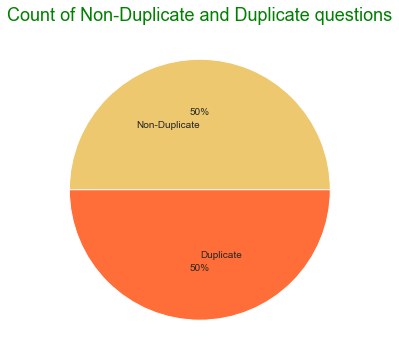

In [70]:
label=['Non-Duplicate', 'Duplicate'] 
color=sns.color_palette('rainbow')[4:6]
plt.figure(figsize=(6,6))
plt.pie(x=class_balance['Count'], labels=label, colors=color, autopct='%.0f%%' , labeldistance=0.5)
plt.title("Count of Non-Duplicate and Duplicate questions", fontsize=18, color='green');

<h2 style="color:blue; background:pink; line-height:1.5">Combine question1 and question2</h2>

In [71]:
data=df[['is_duplicate','question1','question2']]
data['combine_question']=data['question1']+" "+data['question2']
data.head(2)

,is_duplicate,question1,question2,combine_question
0,1,what minor would complement a computer science...,what is a good minor that will compliment a co...,what minor would complement a computer science...
1,1,how can i materialize an idea,what is the best way to materialize on an idea,how can i materialize an idea what is the best...


<h2 style="color:blue; background:pink; line-height:1.5">Input and output feaures</h2>

In [72]:
X=data.drop('is_duplicate', axis=1)
y=data['is_duplicate']
print(X.shape, y.shape)

(49998, 3) (49998,)


<h2 style="color:blue; background:pink; line-height:1.5">Train Test Split</h2>

In [73]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("x train shape=", x_train.shape)
print("y train shape=", y_train.shape)
print("x test shape=", x_test.shape)
print("y test shape=", y_test.shape)

x train shape= (39998, 3)
y train shape= (39998,)
x test shape= (10000, 3)
y test shape= (10000,)


### No need of text preprocessing because we loaded clean data

<h2 style="color:blue; background:pink; line-height:1.5">Convert Text to Numerical Vectors using Word2Vec</h2>

In [16]:
!pip install --upgrade gensim

  Attempting uninstall: gensim
    Found existing installation: gensim 3.8.3
    Uninstalling gensim-3.8.3:
      Successfully uninstalled gensim-3.8.3


In [17]:
import gensim
print(gensim.__version__)

4.3.1


In [18]:
from gensim.models import Word2Vec

<h2 style="color:blue; background:pink; line-height:1.5">Tokenize question 1 and question 2 in both train and test set</h2>

In [74]:
x_train['tokenised_que']=x_train['combine_question'].apply(lambda sent : sent.split())
x_test['tokenised_que']=x_test['combine_question'].apply(lambda sent : sent.split())
x_train.head(2)

,question1,question2,combine_question,tokenised_que
39085,which laptop should i buy under 60k,which laptop should i buy under 60k,which laptop should i buy under 60k which lapt...,"[which, laptop, should, i, buy, under, 60k, wh..."
30892,how hair grow after hair transplant surgery,how long does a hair transplant surgery take,how hair grow after hair transplant surgery ho...,"[how, hair, grow, after, hair, transplant, sur..."


In [75]:
x_test.head(2)

,question1,question2,combine_question,tokenised_que
33552,i am skinny fat what strategy should i follow ...,what will be future for r profile within few y...,i am skinny fat what strategy should i follow ...,"[i, am, skinny, fat, what, strategy, should, i..."
9427,do rich people worry about anything,what do wealthy people worry about,do rich people worry about anything what do we...,"[do, rich, people, worry, about, anything, wha..."


<h2 style="color:blue; background:pink; line-height:1.5">Train Word2vec</h2>

In [76]:
model=Word2Vec(list(x_train['tokenised_que']), vector_size=300, min_count=1)
print(model)

Word2Vec<vocab=28384, vector_size=300, alpha=0.025>


In [77]:
print(model.wv.__getitem__(model.wv.index_to_key).shape) #shape and vectors

(28384, 300)


<h2 style="color:blue; background:pink; line-height:1.5">Drop out of vocabulary words</h2>

In [78]:
def document_vector(doc, keyed_vectors):
    vocab_tokens=[word for word in doc if word in keyed_vectors.index_to_key]
    return np.mean(keyed_vectors.__getitem__(vocab_tokens), axis=0)

x_train['doc_vector']=x_train['tokenised_que'].apply(lambda x : document_vector(x, model.wv))
x_test['doc_vector']=x_test['tokenised_que'].apply(lambda x : document_vector(x, model.wv))
x_train.head(2)

,question1,question2,combine_question,tokenised_que,doc_vector
39085,which laptop should i buy under 60k,which laptop should i buy under 60k,which laptop should i buy under 60k which lapt...,"[which, laptop, should, i, buy, under, 60k, wh...","[0.5163089, 1.143327, -0.3765736, -0.15969498,..."
30892,how hair grow after hair transplant surgery,how long does a hair transplant surgery take,how hair grow after hair transplant surgery ho...,"[how, hair, grow, after, hair, transplant, sur...","[-0.093336016, -0.12793809, -0.391397, 0.05191..."


In [79]:
x_test.head(2)

,question1,question2,combine_question,tokenised_que,doc_vector
33552,i am skinny fat what strategy should i follow ...,what will be future for r profile within few y...,i am skinny fat what strategy should i follow ...,"[i, am, skinny, fat, what, strategy, should, i...","[0.17294537, 0.56007135, -0.4449971, -0.068539..."
9427,do rich people worry about anything,what do wealthy people worry about,do rich people worry about anything what do we...,"[do, rich, people, worry, about, anything, wha...","[0.39128634, 0.058248285, -0.67435503, -0.3872..."


<h2 style="color:blue; background:pink; line-height:1.5">Final Training and Testing Input data</h2>

In [82]:
x_train=list(x_train['doc_vector'])
x_test=list(x_test['doc_vector'])
x_train[1]

array([-0.09333602, -0.12793809, -0.391397  ,  0.0519123 , -0.23897293,
       -0.21923965,  0.3099154 ,  1.0145055 ,  0.01033034,  0.06290798,
       -0.02614345, -0.02081918, -0.03921925, -0.00570612, -0.1671398 ,
       -0.05938331,  0.21705747, -0.03821615,  0.46537787, -0.11892756,
       -0.19223522,  0.03990458, -0.017566  , -0.05015099,  0.16709834,
       -0.20037146, -0.07295357, -0.13245575, -0.0687195 ,  0.0032609 ,
        0.23972768, -0.27767038,  0.5468002 ,  0.10485564, -0.15738791,
        0.46408483, -0.04125812, -0.2368692 , -0.06996179, -0.04705787,
       -0.22185168,  0.27795488, -0.02744282, -0.19848941,  0.12682888,
        0.18774766, -0.08351521,  0.0972618 , -0.10540547,  0.23188826,
        0.39744905,  0.4212891 , -0.04985746,  0.1030757 ,  0.19495712,
        0.27039587,  0.15764578,  0.07369027,  0.6434805 ,  0.31360474,
       -0.5148569 , -0.04711368, -0.06254349, -0.17264405, -0.2402419 ,
       -0.13743769, -0.15940125, -0.06281202, -0.31807563,  0.05

In [83]:
x_test[1]

array([ 0.39128634,  0.05824829, -0.67435503, -0.38728067,  0.25870463,
       -0.27101484,  0.4099125 ,  0.60150933,  0.08744105, -0.0018364 ,
        0.20282757, -0.3130145 , -0.39530775, -0.2780495 , -0.0829564 ,
       -0.12778904,  0.4756894 ,  0.16766985, -0.04829387, -0.5090552 ,
        0.48300648,  0.10350715, -0.30921862, -0.06873912, -0.05845067,
       -0.25837114,  0.30407965, -0.01068853, -0.24240045, -0.20717983,
        0.27365038, -0.01577092, -0.22768529,  0.13769305, -0.04404704,
        0.0536281 ,  0.92454046, -0.20397647,  0.10033055,  0.30085748,
        0.23441292, -0.03329952, -0.00433078, -0.37221575,  0.27377126,
        0.2133765 ,  0.8497443 ,  0.60444564,  0.1178433 , -0.29766312,
        0.10803308,  0.3013216 ,  0.04755261,  0.21548289, -0.05833216,
        0.9097007 ,  0.20131718,  0.185331  ,  0.4600242 ,  0.61587846,
        0.43731704, -0.34796777,  0.00312727,  0.05753926,  0.27910993,
        0.250416  , -0.31572747,  0.00565565, -0.1635577 , -0.11

<h2 style="color:blue; background:pink; line-height:1.5">Building model</h2>

<h2 style="color:blue; background:pink;">Set Experiment<h2>

In [84]:
import mlflow
mlflow.set_experiment("Advance_approach_using_pre_trained_models")

2023/06/04 12:53:10 INFO mlflow.tracking.fluent: Experiment with name 'Advance_approach_using_pre_trained_models' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///D:/DATA%20SCIENCE%20Internship%20with%20Innomatics/Final_%20Project_Quora_Question_Pair_Similarity/mlruns/591167485821976991', creation_time=1685863390057, experiment_id='591167485821976991', last_update_time=1685863390057, lifecycle_stage='active', name='Advance_approach_using_pre_trained_models', tags={}>

<h2 style="color:blue; background:lightgreen; line-height:1">1. Logistic Regression<h2>

----------------------------------------------------------
Acuuracy=0.6666
Precission=0.673305954825462
Recall=0.6529271206690561
F1 Score=0.6629599676506268
----------------------------------------------------------
Confusion Matrix=



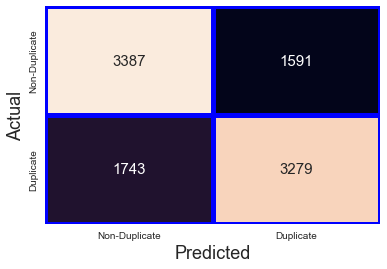

----------------------------------------------------------
Out of 10000 testing values 3334 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.66      0.68      0.67      4978
           1       0.67      0.65      0.66      5022

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.67      0.67      0.67     10000

----------------------------------------------------------


In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
import pickle
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "Logistic word2vec")
    
    log_regression=LogisticRegression()
    log_regression.fit(x_train,y_train)
    pickle.dump(log_regression, open("resources_advance_approach_using_pre_trained_model/logistic_regression_word2vec.pkl","wb"))
    
    y_pred=log_regression.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_using_pre_trained_model/log_reg_word2vec_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(log_regression, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_using_pre_trained_model/log_reg_word2vec_conf_matrix.png")

<h2 style="color:blue; background:lightgreen; line-height:1">2. Naive Bayes<h2>

----------------------------------------------------------
Acuuracy=0.6693
Precission=0.693610295777828
Recall=0.6117084826762246
F1 Score=0.6500899375727436
----------------------------------------------------------
Confusion Matrix=



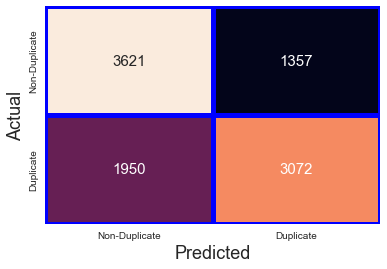

----------------------------------------------------------
Out of 10000 testing values 3307 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.65      0.73      0.69      4978
           1       0.69      0.61      0.65      5022

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.67      0.67      0.67     10000

----------------------------------------------------------


In [89]:
from sklearn.naive_bayes import GaussianNB
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "Naive Bayes word2vec")
    
    naive_classifier=GaussianNB()
    naive_classifier.fit(x_train,y_train)
    pickle.dump(naive_classifier, open("resources_advance_approach_using_pre_trained_model/naive_word2vec.pkl","wb"))
    
    y_pred=naive_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_using_pre_trained_model/naive_word2vec_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(naive_classifier, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_using_pre_trained_model/naive_word2vec_conf_matrix.png")

<h2 style="color:blue; background:lightgreen; line-height:1">3. Decision Tree</h2>

----------------------------------------------------------
Acuuracy=0.6337
Precission=0.635872825434913
Recall=0.6332138590203107
F1 Score=0.634540556719545
----------------------------------------------------------
Confusion Matrix=



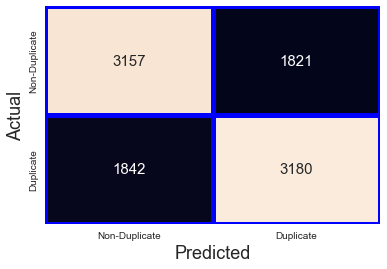

----------------------------------------------------------
Out of 10000 testing values 3663 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.63      0.63      0.63      4978
           1       0.64      0.63      0.63      5022

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.63      0.63      0.63     10000

----------------------------------------------------------


In [90]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
import pickle
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "Decision Tree word2vec")
    
    dt_classifier=DecisionTreeClassifier()
    dt_classifier.fit(x_train,y_train)
    pickle.dump(dt_classifier, open("resources_advance_approach_using_pre_trained_model/decision_tree_word2vec.pkl","wb"))
    
    y_pred=dt_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_using_pre_trained_model/decision_tree_word2vec_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(dt_classifier, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_using_pre_trained_model/decision_tree_word2vec_conf_matrix.png")

<h2 style="color:blue; background:lightgreen; line-height:1">4. Random Forest</h2>

----------------------------------------------------------
Acuuracy=0.7255
Precission=0.7181452385514466
Recall=0.7463162086818
F1 Score=0.7319597695537545
----------------------------------------------------------
Confusion Matrix=



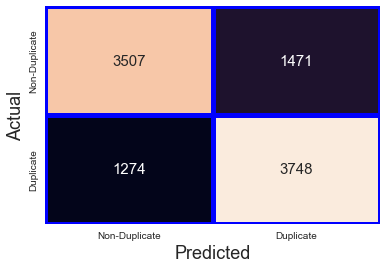

----------------------------------------------------------
Out of 10000 testing values 2745 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.73      0.70      0.72      4978
           1       0.72      0.75      0.73      5022

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000

----------------------------------------------------------


In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
import pickle
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "Random Forest word2vec")
    
    rf_classifier=RandomForestClassifier()
    rf_classifier.fit(x_train,y_train)
    pickle.dump(rf_classifier, open("resources_advance_approach_using_pre_trained_model/random_forest_word2vec.pkl","wb"))
    
    y_pred=rf_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_using_pre_trained_model/random_forest_word2vec_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(rf_classifier, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_using_pre_trained_model/random_forest_word2vec_conf_matrix.png")

<h2 style="color:blue; background:lightgreen; line-height:1">5. Gradient Boosting</h2>

----------------------------------------------------------
Acuuracy=0.7001
Precission=0.7077428630108852
Recall=0.6861808044603743
F1 Score=0.6967950662218177
----------------------------------------------------------
Confusion Matrix=



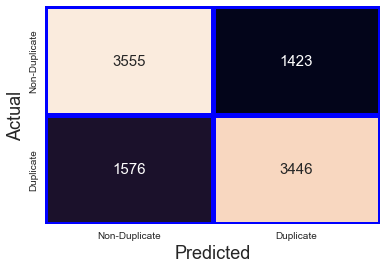

----------------------------------------------------------
Out of 10000 testing values 2999 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.69      0.71      0.70      4978
           1       0.71      0.69      0.70      5022

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000

----------------------------------------------------------


In [94]:
from sklearn.ensemble import GradientBoostingClassifier
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "Gradient Boost word2vec")
    
    gb_classifier=GradientBoostingClassifier()
    gb_classifier.fit(x_train,y_train)
    pickle.dump(gb_classifier, open("resources_advance_approach_using_pre_trained_model/gradient_boostig_word2vec.pkl","wb"))
    
    y_pred=gb_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_using_pre_trained_model/gradient_boost_word2vec_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(gb_classifier, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_using_pre_trained_model/gradient_boost_word2vec_conf_matrix.png")

<h2 style="color:blue; background:lightgreen; line-height:1">6. Ada Boost</h2>

----------------------------------------------------------
Acuuracy=0.6792
Precission=0.689194826866917
Recall=0.657905217045002
F1 Score=0.6731866340668297
----------------------------------------------------------
Confusion Matrix=



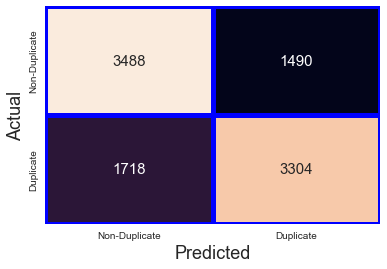

----------------------------------------------------------
Out of 10000 testing values 3208 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.67      0.70      0.68      4978
           1       0.69      0.66      0.67      5022

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.68      0.68     10000

----------------------------------------------------------


In [92]:
from sklearn.ensemble import AdaBoostClassifier
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "Ada Boost word2vec")
    
    ada_classifier=AdaBoostClassifier()
    ada_classifier.fit(x_train,y_train)
    pickle.dump(ada_classifier, open("resources_advance_approach_using_pre_trained_model/ada_boosting_word2vec.pkl","wb"))
    
    y_pred=ada_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_using_pre_trained_model/ada_boost_word2vec_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(ada_classifier, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_using_pre_trained_model/ada_boost_word2vec_conf_matrix.png")

<h2 style="color:blue; background:lightgreen; line-height:1">7. XG Boost</h2>

----------------------------------------------------------
Acuuracy=0.7091
Precission=0.7140830800405269
Recall=0.7017124651533254
F1 Score=0.7078437280305312
----------------------------------------------------------
Confusion Matrix=



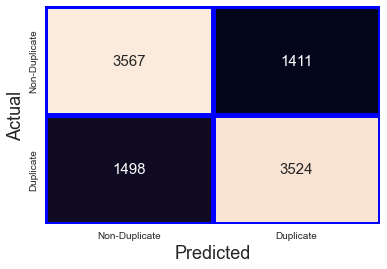

----------------------------------------------------------
Out of 10000 testing values 2909 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.70      0.72      0.71      4978
           1       0.71      0.70      0.71      5022

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000

----------------------------------------------------------


In [91]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
import pickle
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "XG Boost word2vec")
    
    xgb_classifier=XGBClassifier()
    xgb_classifier.fit(x_train,y_train)
    pickle.dump(xgb_classifier, open("resources_advance_approach_using_pre_trained_model/xgboost_word2vec.pkl","wb"))
    
    y_pred=xgb_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_using_pre_trained_model/xgboost_word2vec_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(xgb_classifier, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_using_pre_trained_model/xgboost_word2vec_conf_matrix.png")

### Inference:
 **Accuracy of Random Forest model is high(73%).**